In [9]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from collections import Counter

# Configurar pandas para ver texto completo
pd.set_option('display.max_colwidth', 150)

# Cargar el dataset limpio que se guardó antes
try:
    df = pd.read_csv('../data/datos_triaje_limpios_2.csv')
    print(f"✅ Datos cargados correctamente. Total de filas: {len(df)}")
except FileNotFoundError:
    print("❌ Error: No se encuentra el archivo. Verifica que se ejecuto el Notebook 1.")

# Cargar el modelo de lenguaje en español de Spacy
try:
    nlp = spacy.load("es_core_news_sm")
    print("✅ Modelo de lenguaje español (SpaCy) cargado.")
except OSError:
    print("❌ Error: Modelo de SpaCy no encontrado. Ejecuta en tu terminal: python -m spacy download es_core_news_sm")

✅ Datos cargados correctamente. Total de filas: 3005
✅ Modelo de lenguaje español (SpaCy) cargado.


In [11]:
# Definir las palabras que no se quieren eliminar (negaciones)
negaciones = {'no', 'sin', 'ni', 'nunca', 'jamás', 'tampoco'}

# Definir las palabras que se quiere eliminar (stopwords)
stopwords = nlp.Defaults.stop_words

# Ajustar las stopwords para que las negaciones no se eliminen
for palabra in negaciones:
    nlp.vocab[palabra].is_stop = False

def procesar_texto_medico(texto):
    # 1. Convertir a objeto SpaCy (Tokenización automática)
    doc = nlp(texto)
    
    tokens_limpios = []
    
    for token in doc:
        # Filtros:
        # - Que no sea signo de puntuación (is_punct)
        # - Que no sea una 'stopword' (is_stop)
        # - Que sea letras y no números sueltos (is_alpha)
        if not token.is_punct and not token.is_stop and token.is_alpha:
            # 2. Lematización: Tomar la raíz de la palabra (lemma_) y se pasa a minúsculas
            tokens_limpios.append(token.lemma_.lower())
            
    # Unir las palabras limpias de nuevo en una frase
    return " ".join(tokens_limpios)

# Probemos la función con un ejemplo
ejemplo = "El paciente presenta dolores fuertes en el abdomen y vómitos constantes, ademas no presenta dolor de espalda. Sin toma de medicamentos previos."
print(f"Original: {ejemplo}")
print(f"Procesado: {procesar_texto_medico(ejemplo)}")

Original: El paciente presenta dolores fuertes en el abdomen y vómitos constantes, ademas no presenta dolor de espalda. Sin toma de medicamentos previos.
Procesado: paciente presentar dolor fuerte abdomen vómito constante no presentar dolor espalda toma medicamento previo


In [12]:
print("⏳ Procesando todo el dataset (esto puede tardar unos segundos)...")

# Aplicar la función a la columna 'sintomas'
df['sintomas_procesados'] = df['sintomas'].apply(procesar_texto_medico)

print("✅ ¡Procesamiento terminado!")

# Comparar el Antes y el Después
display(df[['sintomas', 'sintomas_procesados']].head(5))

⏳ Procesando todo el dataset (esto puede tardar unos segundos)...
✅ ¡Procesamiento terminado!


,sintomas,sintomas_procesados
0,"Varón de 13 años, sin antecedentes personales de interés, que acude a la consulta del centro de salud porque desde hace unos meses ha notado una l...",varón año sin antecedente personal interés acudir consulta centro salud mes notar lesión pierna izquierdo no ocasionar sintomatología no variar ta...
1,"EXAMEN: , CT Abdomen y Pelvis con contraste ,MOTIVO DEL EXAMEN:, Náuseas, vómitos, diarrea por un día. Fiebre. Dolor en hipocondrio derecho dura...",examen ct abdomen pelvis contraste motivo examen náuseas vómito diarrea fiebre dolor hipocondrio derecho comparación técnica tc abdomen pelvis rea...
2,QUEJA PRINCIPAL: Dolor de cadera. ANTECEDENTES DE LA ENFERMEDAD PRESENTE: La paciente es una mujer blanca de 41 años muy agradable que conozco ant...,queja principal dolor cadera antecedente enfermedad presente paciente mujer blanco año agradable conocer anteriormente trabajo clínica manejo dolo...
3,"DIAGNÓSTICO PREOPERATORIO: , Hemorragia postoperatoria.,DIAGNÓSTICO POSTOPERATORIO:, Hemorragia postoperatoria.,PROCEDIMIENTO QUIRÚRGICO: ,Examen ...",diagnóstico preoperatorio hemorragia postoperatorio postoperatorio hemorragia postoperatorio quirúrgico examen anestesia control hemorragia espaci...
4,"DIAGNÓSTICO PREOPERATORIO: Mal funcionamiento del shunt. El paciente con derivación ventriculoauricular.,DIAGNÓSTICO POSTOPERATORIO: Mal funciona...",diagnóstico preoperatorio funcionamiento shunt paciente derivación ventriculoauricular postoperatorio funcionamiento derivación paciente derivació...


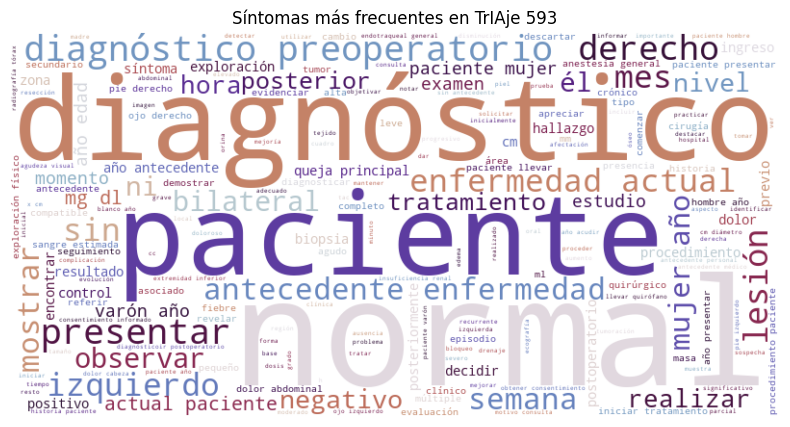

In [13]:
from wordcloud import WordCloud

# Unir todo el texto procesado en un solo bloque gigante
texto_completo = " ".join(df['sintomas_procesados'])

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='twilight').generate(texto_completo)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Síntomas más frecuentes en TrIAje 593')
plt.show()

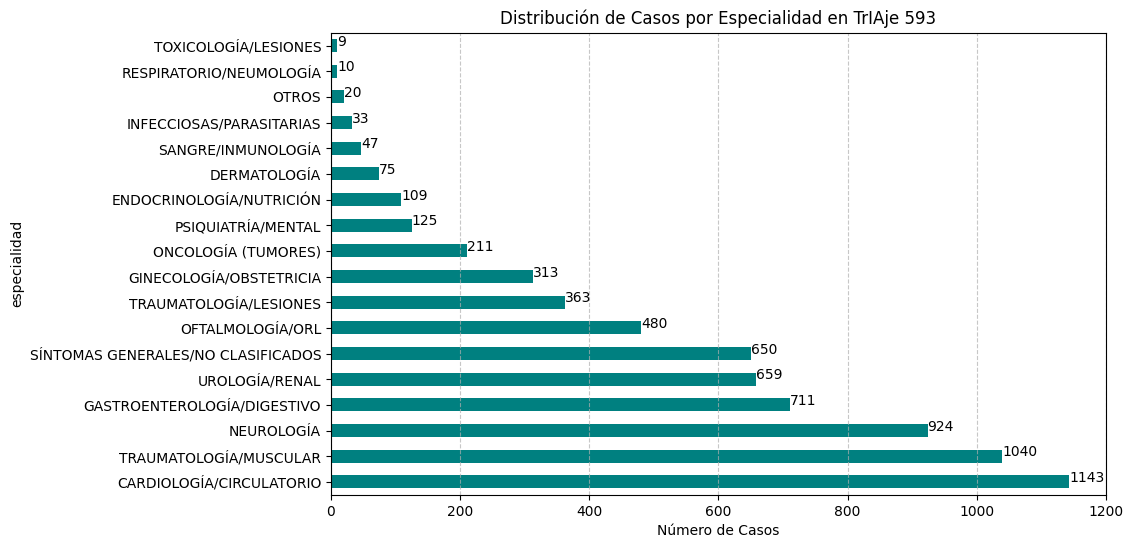

In [15]:
df_procesado = pd.read_csv('../data/datos_nlp_procesados.csv')
# Ver cuántos casos se tiene por especialidad (Importante para saber si está balanceado)
plt.figure(figsize=(10,6))
df_procesado['especialidad'].value_counts().plot(kind='barh', color='teal')
plt.title('Distribución de Casos por Especialidad en TrIAje 593')
plt.xlabel('Número de Casos')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar los valores en el gráfico
conteo = df_procesado['especialidad'].value_counts().values
for index, value in enumerate(conteo):
    plt.text(value, index, str(value))

plt.show()

In [19]:
# ==========================================
# 🔧 CORRECCIÓN DE CLASES (SOLO SI EN LA GRAFICA ANTERIOR SE VE DESBALANCEADO)
# ==========================================

print("Clases originales:", df_procesado['especialidad'].nunique())

# 1. Función para unificar especialidades confusas
def unificar_categorias(especialidad):
    especialidad = especialidad.upper()
    
    # Fusión de Traumatología (La clave para subir precisión)
    if 'TRAUMATOLOGÍA' in especialidad: 
        return 'TRAUMATOLOGÍA/MUSCULAR'
    
    # Fusión de clases muy pequeñas (< 20 datos) en 'OTROS'
    # Esto evita que el modelo trate de adivinar cosas que no sabe
    elif especialidad in ['RESPIRATORIO/NEUMOLOGÍA', 'TOXICOLOGÍA/LESIONES', 
                          'INFECCIOSAS/PARASITARIAS', 'SANGRE/INMUNOLOGÍA', 'OTROS']:
        return 'SÍNTOMAS GENERALES/NO CLASIFICADOS'
        
    return especialidad

# 2. Aplicar la corrección
df_procesado['especialidad_corr'] = df_procesado['especialidad'].apply(unificar_categorias)

# 3. Filtrar la clase 'OTROS' si quieres precisión pura 
# (Opcional: Si dejas 'OTROS', la precisión bajará un poco pero el sistema será más realista. 
#  Para el 80% académico, sugiero sacarla temporalmente o dejarla si son pocos datos).
df = df_procesado[df_procesado['especialidad_corr'] != 'SÍNTOMAS GENERALES/NO CLASIFICADOS'] 


print("✅ Nuevas Clases Unificadas:", df['especialidad_corr'].unique())
print("Total de clases ahora:", len(df['especialidad_corr'].unique()))

# Mostrar clases
for clase in df['especialidad_corr'].unique():
    print("-", clase)

Clases originales: 18
✅ Nuevas Clases Unificadas: ['CARDIOLOGÍA/CIRCULATORIO' 'TRAUMATOLOGÍA/MUSCULAR' 'OFTALMOLOGÍA/ORL'
 'NEUROLOGÍA' 'GASTROENTEROLOGÍA/DIGESTIVO' 'PSIQUIATRÍA/MENTAL'
 'UROLOGÍA/RENAL' 'GINECOLOGÍA/OBSTETRICIA' 'DERMATOLOGÍA'
 'ONCOLOGÍA (TUMORES)' 'ENDOCRINOLOGÍA/NUTRICIÓN']
Total de clases ahora: 11
- CARDIOLOGÍA/CIRCULATORIO
- TRAUMATOLOGÍA/MUSCULAR
- OFTALMOLOGÍA/ORL
- NEUROLOGÍA
- GASTROENTEROLOGÍA/DIGESTIVO
- PSIQUIATRÍA/MENTAL
- UROLOGÍA/RENAL
- GINECOLOGÍA/OBSTETRICIA
- DERMATOLOGÍA
- ONCOLOGÍA (TUMORES)
- ENDOCRINOLOGÍA/NUTRICIÓN


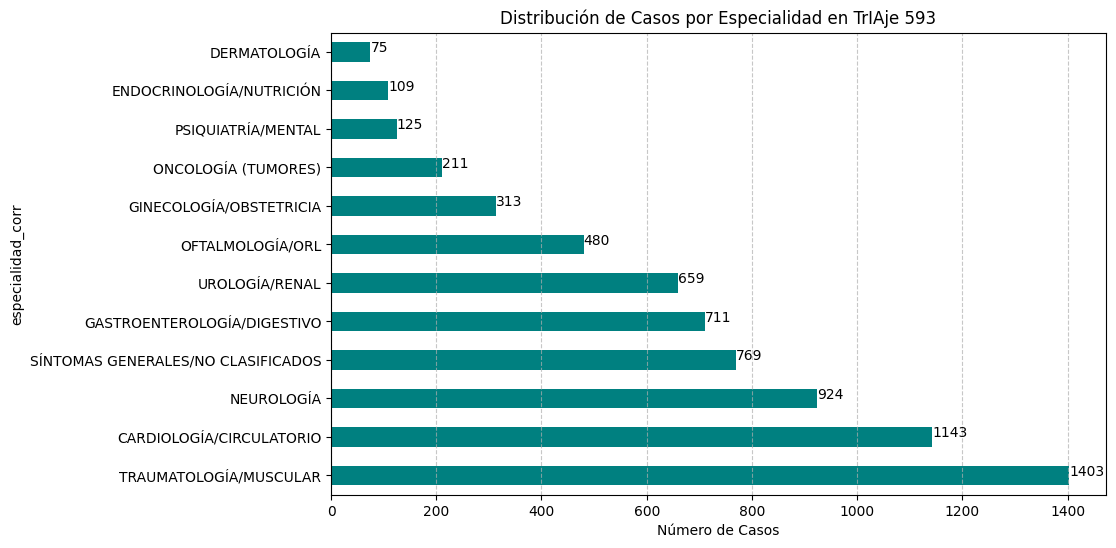

In [17]:
# Ver cuántos casos se tiene por especialidad (Importante para saber si está balanceado)
plt.figure(figsize=(10,6))
df_procesado['especialidad_corr'].value_counts().plot(kind='barh', color='teal')
plt.title('Distribución de Casos por Especialidad en TrIAje 593')
plt.xlabel('Número de Casos')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar los valores en el gráfico
conteo = df_procesado['especialidad_corr'].value_counts().values
for index, value in enumerate(conteo):
    plt.text(value, index, str(value))

In [18]:
# Eliminar filas que hayan quedado vacías después de la limpieza
df_final = df_procesado[df_procesado['sintomas_procesados'].str.strip() != '']

df_final.to_csv('../data/datos_nlp_procesados_2.csv', index=False)
print("✅ Archivo 'datos_nlp_procesados_2.csv' guardado en /data.")

✅ Archivo 'datos_nlp_procesados_2.csv' guardado en /data.
